# Ouroboros: summary statistics

This notebook covers all the experiments performed for testing the Ouroboros framework for early identification of at-risk students

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

BASE_PATH = os.path.dirname(os.path.abspath('__file__'))

SELF_LEARNER_MODULE_PATH = os.path.abspath(os.path.join(BASE_PATH, os.path.pardir))
SELF_LEARNER_LIB_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'selflearner')

os.chdir(SELF_LEARNER_LIB_PATH)
sys.path.append(SELF_LEARNER_MODULE_PATH)

DATA_PATH = os.path.join(SELF_LEARNER_LIB_PATH, 'data_load')
DATA_PATH = os.path.join(DATA_PATH, 'data')
DATA_HDF5_PATH = os.path.join(DATA_PATH, 'selflearner.h5')
hdf5_path = os.path.join(DATA_PATH, 'oulad.h5')
OULAD_URL = 'https://analyse.kmi.open.ac.uk/open_dataset/download'
OULAD_MD5_URL = ' https://analyse.kmi.open.ac.uk/open_dataset/downloadCheckSum'

DS_ASSESSMENTS = 'assessments'
DS_COURSES = 'courses'
DS_STUD_ASSESSMENTS = 'studentAssessment'
DS_STUD_INFO = 'studentInfo'
DS_STUD_REG = 'studentRegistration'
DS_STUD_VLE = 'studentVle'
DS_VLE = 'vle'

from selflearner.data_load.feature_extraction import FeatureExtraction
from selflearner.data_load.hdf5.pytables_hdf5_manager import PytablesHdf5Manager
from selflearner.data_load.hdf5.pytables_descriptions import ConfigDescriptionOulad
from selflearner.data_load.features_utils import FeaturesMapping

store_manager = PytablesHdf5Manager(hdf5_path)
dfs = {
            DS_COURSES: store_manager.load_dataframe(DS_COURSES),
            DS_ASSESSMENTS: store_manager.load_dataframe(DS_ASSESSMENTS),
            DS_VLE: store_manager.load_dataframe(DS_VLE),
            DS_STUD_INFO: store_manager.load_dataframe(DS_STUD_INFO),
            DS_STUD_ASSESSMENTS: store_manager.load_dataframe(DS_STUD_ASSESSMENTS),
            DS_STUD_REG: store_manager.load_dataframe(DS_STUD_REG),
            DS_STUD_VLE: store_manager.load_dataframe(DS_STUD_VLE)
        }

df_courses = dfs[DS_COURSES]
df_stud = dfs[DS_STUD_INFO].reset_index()
df_ass = dfs[DS_ASSESSMENTS].drop(dfs[DS_ASSESSMENTS].columns[[0,1]], axis=1).reset_index()
df_stud_ass = dfs[DS_STUD_ASSESSMENTS].reset_index()
df_stud_reg = dfs[DS_STUD_REG]
df_stud_vle = dfs[DS_STUD_VLE]


def percConvert(ser):
  return ser/float(ser[-1])

## Basic dataset statistics

Number of students in the courses, number of passed/failed students and the pass rates.

In [2]:
# Count of students
df_course_stats = pd.DataFrame(df_stud.groupby(['code_module','code_presentation'], as_index=False).size(), columns=['student_count'])

# Pass rates
from data_load.features_utils import FeaturesMapping
df_stud['passed'] = df_stud.apply(lambda row: FeaturesMapping.result_to_pass_fail(row), axis=1)
df_passed_stat = df_stud.groupby(['code_module','code_presentation','passed']).agg({'passed' : {'count':'count'}})
df_passed_stat.columns = df_passed_stat.columns.droplevel(0)
# df_passed_stat = df_passed_stat.reset_index() 
df_passed_stat = df_passed_stat.unstack(level=2).reset_index()
df_passed_stat.columns = df_passed_stat.columns.droplevel(0)
df_passed_stat.columns = ['code_module','code_presentation','passed_count','failed_count']
df_passed_stat['registered'] = (df_passed_stat['passed_count'] + df_passed_stat['failed_count'])
df_passed_stat['pass_rate'] = df_passed_stat['passed_count'] / df_passed_stat['registered']
df_passed_stat.loc[df_passed_stat['code_presentation'] == '2014J'] 

,code_module,code_presentation,passed_count,failed_count,registered,pass_rate
1,AAA,2014J,112,253,365,0.306849
5,BBB,2014J,1140,1152,2292,0.497382
7,CCC,2014J,1483,1015,2498,0.593675
11,DDD,2014J,1011,792,1803,0.560732
14,EEE,2014J,504,684,1188,0.424242
18,FFF,2014J,1248,1117,2365,0.527696
21,GGG,2014J,305,444,749,0.407210


### Assessment statistics

In [3]:
assessment_name="TMA 1"

df_ass_sel = df_ass.loc[df_ass['assessment_name'] == assessment_name][['code_module','code_presentation','date','weight']]
df_ass_sel.sort_values('code_module')

,code_module,code_presentation,date,weight
3,AAA,2013J,19.0,10.0
9,AAA,2014J,19.0,10.0
0,BBB,2014B,12.0,5.0
5,BBB,2014J,19.0,0.0
6,BBB,2013J,19.0,5.0
7,BBB,2013B,19.0,5.0
18,CCC,2014J,32.0,9.0
17,CCC,2014B,32.0,9.0
10,DDD,2014J,20.0,5.0
14,DDD,2014B,25.0,10.0


It can be seen that there is little bit of correlation between the cutoff-date and the weight of the TMA, apart from one exception - here the cutoff is in date 60 with 0 importance, ,this is for GGG course.

### TMA1 probabilities of submission and the subsequent pass/fail in the module.

In [4]:
# TMA1
df_tma1 = df_ass.loc[ df_ass['assessment_name'] == 'TMA 1']

df_stud_tma1 = df_stud_ass.merge(right=df_tma1, how='inner', left_on='id_assessment', right_on='id_assessment', sort=False)
df_tma1_stat = df_stud_tma1.groupby(['code_module','code_presentation']).agg({'score' : {'count' : 'count', 'avg':'mean', 'sum':'sum'} } ).reset_index()
df_tma1_stat.columns = df_tma1_stat.columns.droplevel(0)
df_tma1_stat.columns = ['code_module','code_presentation','avg_submitted','sum', 'count_submitted']

df_tma1_stat = df_tma1_stat.merge(right=df_passed_stat, left_on=['code_module', 'code_presentation'], right_on=['code_module', 'code_presentation'], how='inner')
df_tma1_stat['submitted_tma1_pct'] = df_tma1_stat['count_submitted'] / df_tma1_stat['registered']

# df_tma1_stat

In [5]:
# Submission rate for all the modules by given presentation
# df_tma1_stat
df_tma1_stat.loc[df_tma1_stat['code_presentation'] == '2014J']

,code_module,code_presentation,avg_submitted,sum,count_submitted,passed_count,failed_count,registered,pass_rate,submitted_tma1_pct
1,AAA,2014J,69.255193,337,23339.0,112,253,365,0.306849,63.942466
5,BBB,2014J,58.866817,1772,104312.0,1140,1152,2292,0.497382,45.511344
7,CCC,2014J,78.790175,1425,112276.0,1483,1015,2498,0.593675,44.946357
11,DDD,2014J,72.288339,1415,102288.0,1011,792,1803,0.560732,56.732113
14,EEE,2014J,86.117330,929,80003.0,504,684,1188,0.424242,67.342593
18,FFF,2014J,78.598684,1824,143364.0,1248,1117,2365,0.527696,60.619027
21,GGG,2014J,66.599315,584,38894.0,305,444,749,0.407210,51.927904


In [6]:
df_stud_all_ass = df_stud.merge(right=df_ass, on=['code_module','code_presentation'], how='left')
df_stud_all_ass = df_stud_all_ass.merge(right=df_stud_ass, how='left', on=['id_student','id_assessment'], sort=False)
df_stud_all_ass['submitted'] = df_stud_all_ass['score'].notnull()
df_stud_all_ass['succeeded'] = df_stud_all_ass['score'] > 49

# df_stud_all_ass['submitted'] = df_stud_all_ass['submitted'].fillna(0)
pivoted = df_stud_all_ass.set_index(['code_module', 'code_presentation', 'id_student','assessment_name'])[['succeeded']]
df_stud_tma_results = pivoted.unstack()
df_stud_tma_results.columns.name = None
df_stud_tma_results = df_stud_tma_results.merge(df_stud, left_index=['code_module', 'code_presentation','id_student'], right_on=['code_module', 'code_presentation','id_student'], how='inner')
df_stud_tma_results.columns = ["CMA 1", "CMA 2","CMA 3", "CMA 4","CMA 5","CMA 6","CMA 7", \
"Exam","Exam 2", \
"TMA 1","TMA 2","TMA 3","TMA 4","TMA 5","TMA 6"] + list(df_stud_tma_results.columns[15:].values)

df_stud_tma_results.head()

/usr/local/lib/python3.5/site-packages/pandas/tools/merge.py:480: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,CMA 1,CMA 2,CMA 3,CMA 4,CMA 5,CMA 6,CMA 7,Exam,Exam 2,TMA 1,TMA 2,TMA 3,TMA 4,TMA 5,TMA 6,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,passed
0,None,None,None,None,None,None,None,False,None,True,True,True,True,True,None,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,Pass
1,None,None,None,None,None,None,None,False,None,True,True,True,True,True,None,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,Pass
2,None,None,None,None,None,None,None,False,None,False,False,False,False,False,None,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,Fail
3,None,None,None,None,None,None,None,False,None,True,True,True,True,True,None,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,Pass
4,None,None,None,None,None,None,None,False,None,True,False,True,False,True,None,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,Pass


In [7]:
def fail_if_tmafail(df):
    exams = ["CMA 1", "CMA 2","CMA 3", "CMA 4","CMA 5","CMA 6","CMA 7", "Exam","Exam 2","TMA 1","TMA 2","TMA 3","TMA 4","TMA 5","TMA 6"]
    allseries = pd.Series()
    lenexams = 0
    indexexams = []

    for exam in exams:
        if df[exam].notnull().all():
            s = pd.crosstab(df[exam], df['passed'], margins=True).apply(percConvert, axis=1)['Fail'][0:2]
            lenexams = lenexams + 1
            
            allseries = allseries.append(s)
            indexexams.append(exam)
            
    df_exam_pp = pd.DataFrame(allseries.reshape(lenexams,2), columns=["NS","S"], index=indexexams)
    return df_exam_pp

def tma_fail_pp(df, exam="TMA 1"):
    modules = df['code_module'].unique()
    presentations = df['code_presentation'].unique()
    allseries = pd.Series()
    indexes = []
    
    for module in modules:
        for pres in presentations:
            df_course = df.loc[(df['code_module'] == module) & (df['code_presentation'] == pres)]
            if(len(df_course) > 0 and df_course[exam].notnull().all()):
                s = pd.crosstab(df_course[exam], df_course['passed'], margins=True).apply(percConvert, axis=1)['Fail'][0:2]
                allseries = allseries.append(s)
                indexes.append((module,pres))
            
    df_exam_pp = pd.DataFrame(allseries.reshape(len(indexes),2), columns=["NS","S"], index=pd.MultiIndex.from_tuples(indexes))
    return df_exam_pp

In [8]:
exam='TMA 1'
df=tma_fail_pp(df_stud_tma_results, exam=exam).reset_index()
df.columns = ['code_module','code_presentation','NS','S']
df_filtered = df_ass.loc[df_ass['assessment_name'] == exam][['code_module','code_presentation','date','weight']]
df_s_ns = df.merge(right=df_filtered, on=['code_module','code_presentation'])

df_s_ns_grouped = df_s_ns.groupby(['code_module'])
df_s_ns_grouped.mean()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:32: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


,NS,S,date,weight
code_module,,,,
AAA,0.800435,0.220036,19.00,10.000
BBB,0.880914,0.361313,17.25,3.750
CCC,0.838138,0.377094,32.00,9.000
DDD,0.965112,0.417039,23.75,8.125
EEE,0.980799,0.271695,33.00,16.000
FFF,0.980450,0.409291,21.50,12.500
GGG,0.829965,0.257326,61.00,0.000


### Does the weight of TMA1 influence the submission rate?

The question is to examine, whether some of the properties of the TMA1 has influence on the success, if the TMA was or was not submitted - e.g. $P(SUCCESS| TMA\_submitted,x)$ and $P(SUCCESS| TMA\_not\_submitted,x)$, given some property $x$ about the TMA.

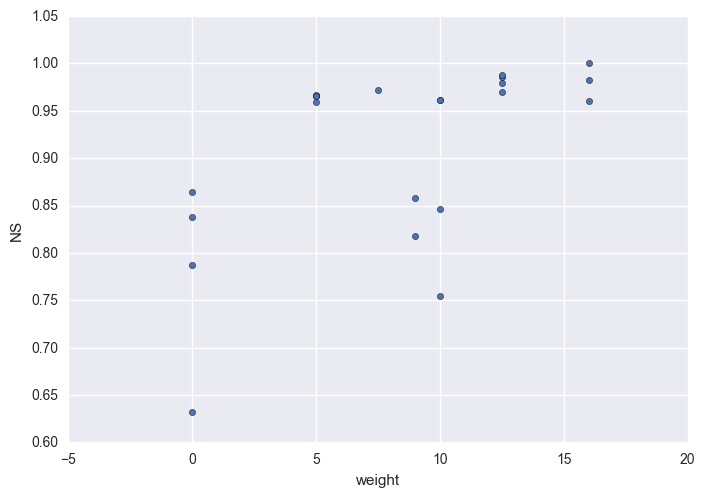

In [9]:
# Weight of the assessment:
df_s_ns.plot(kind='scatter', x='weight', y='NS')

## Student withdrawal 

When do students withdraw from the courses?

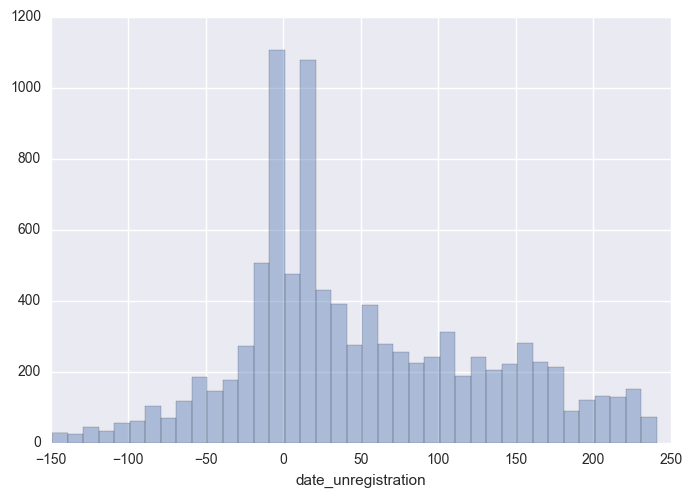

In [10]:
df_unregistered = df_stud_reg[df_stud_reg['date_unregistration'].notnull()].reset_index()
df_unregistered = df_unregistered[df_unregistered['date_unregistration'] > -150]
df_unregistered = df_unregistered[df_unregistered['date_unregistration'] <= 250]

# df_unregistered.groupby(by='date_unregistration').size().order()
df_unregistered = df_unregistered[df_unregistered['code_module'] != 'AAA']
# df_unregistered = df_unregistered[df_unregistered['code_presentation'] != '2013B']
df_unregistered = df_unregistered[df_unregistered['code_module'] != 'GGG']

s_unregistered = df_unregistered['date_unregistration']
sns.distplot(s_unregistered, norm_hist=False, kde=False)

The same distribution of date unregistration, but now per module/presentation.

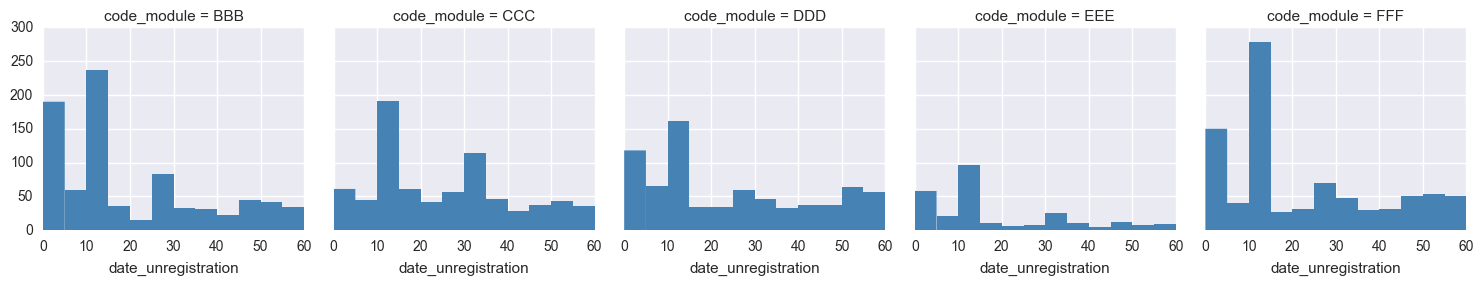

In [11]:
g = sns.FacetGrid(df_unregistered,col="code_module", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "date_unregistration", color="steelblue", bins=bins, lw=0)